# LVLM Encoder Explainability

In [1]:
!pip install einops ftfy captum regex

import CLIP.clip as clip
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import visualization
import torch


## General Attention-model Explainability

In [2]:
#@title Control context expansion (number of attention layers to consider)
#@title Number of layers for image Transformer
start_layer =  -1#@param {type:"number"}

#@title Number of layers for text Transformer
start_layer_text =  -1#@param {type:"number"}

def interpret(image, texts, model, device, start_layer=start_layer, start_layer_text=start_layer_text):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts)
    #
    # print(logits_per_image)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())

    if start_layer == -1:
      # calculate index of last layer
      start_layer = len(image_attn_blocks) - 1

    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(image_attn_blocks):
        if i < start_layer:
            continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R = R + torch.bmm(cam, R)
    image_relevance = R[:, 0, 1:]


    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())

    if start_layer_text == -1:
      # calculate index of last layer
      start_layer_text = len(text_attn_blocks) - 1

    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(text_attn_blocks):
        if i < start_layer_text:
            continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R_text = R_text + torch.bmm(cam, R_text)
    text_relevance = R_text

    return text_relevance, image_relevance, logits_per_text, logits_per_image

## Show Image and Text Relevance

In [3]:
import matplotlib.pyplot as plt

def show_image_relevance(image_relevance, image, orig_image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        cmap = plt.get_cmap('jet')
        rgba_img = cmap(mask)
        heatmap = np.delete(rgba_img, 3, 2)
        cam = np.float32(heatmap) / np.max(heatmap)
        cam = (cam + img)/2
        return cam

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image);
    axs[0].axis('off');

    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    axs[1].imshow(vis);
    axs[1].axis('off');

from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
_tokenizer = _Tokenizer()

def show_heatmap_on_text(text, text_encoding, R_text):
    CLS_idx = text_encoding.argmax(dim=-1)
    R_text = R_text[CLS_idx, 1:CLS_idx]
    text_scores = R_text / R_text.sum()
    text_scores = text_scores.flatten()
    # print(text_scores)
    text_tokens=_tokenizer.encode(text)
    text_tokens_decoded=[_tokenizer.decode([a]) for a in text_tokens]
    vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,text_tokens_decoded,1)]
    visualization.visualize_text(vis_data_records)

# Examples

In [ ]:
clip._MODELS = {
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
    "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
    "ViT-L/14": "https://openaipublic.azureedge.net/clip/models/b8cca3fd41ae0c99ba7e8951adf17d267cdb84cd88be6f7c2e0eca1737a03836/ViT-L-14.pt",
}

class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

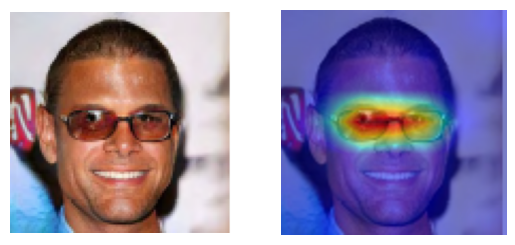

In [7]:
img_path = "images/glasses.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["a man with eyeglasses"]
text = clip.tokenize(texts).to(device)

R_text, R_image, logits_per_text, logits_per_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
    show_heatmap_on_text(texts[i], text[i], R_text[i])
    show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
    plt.show()

CLIP similarity score: 24.734375


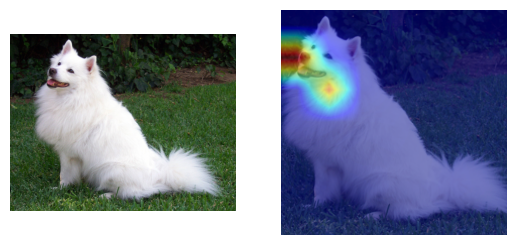

In [8]:
img_path = "images/dog.jpg"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["a happy dog"]
text = clip.tokenize(texts).to(device)

R_text, R_image, logits_per_text, logits_per_image = interpret(model=model, image=img, texts=text, device=device)
print(color.BOLD + color.PURPLE + color.UNDERLINE + f'CLIP similarity score: {logits_per_image.item()}' + color.END)
batch_size = text.shape[0]
for i in range(batch_size):
    show_heatmap_on_text(texts[i], text[i], R_text[i])
    show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
    plt.show()



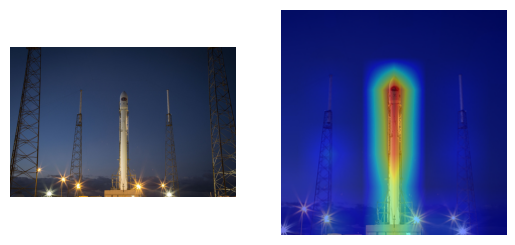

In [9]:
img_path = "images/rocket.jpg"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["a rocket standing on a launchpad"]
text = clip.tokenize(texts).to(device)

R_text, R_image, logits_per_text, logits_per_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

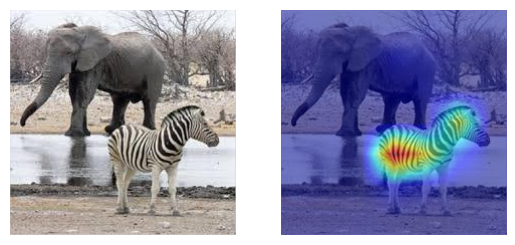

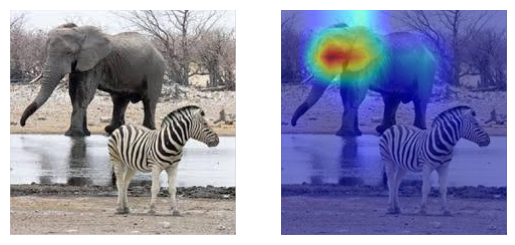

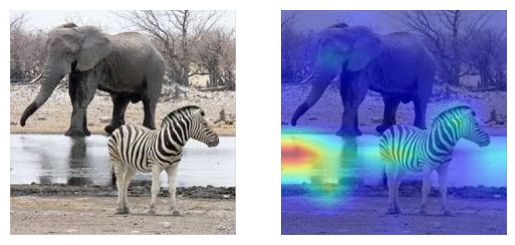

In [10]:
img_path = "images/el2.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ['a zebra', 'an elephant', 'a lake']
text = clip.tokenize(texts).to(device)

R_text, R_image, logits_per_text, logits_per_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

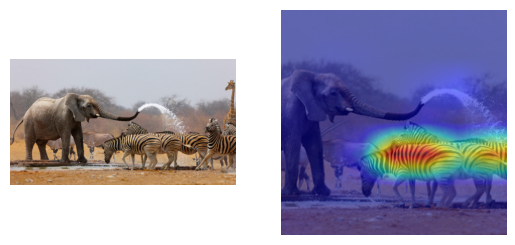

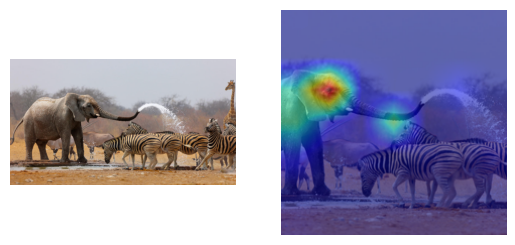

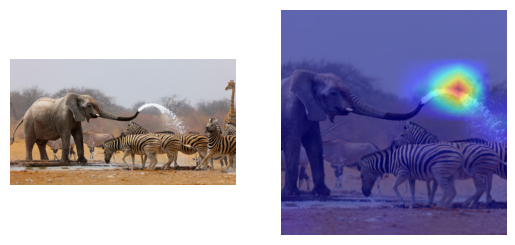

In [11]:
img_path = "images/el3.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ['a zebra', 'an elephant', 'water']
text = clip.tokenize(texts).to(device)

R_text, R_image, logits_per_text, logits_per_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

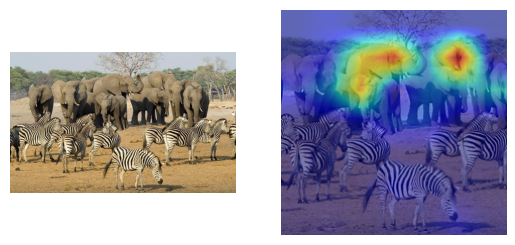

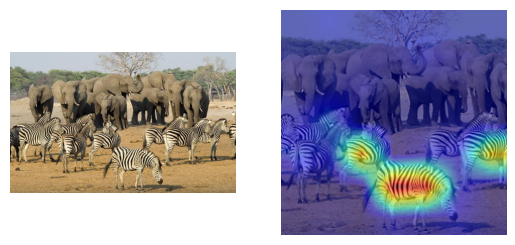

In [12]:
img_path = "images/el4.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ['an elephant', 'a zebra']
text = clip.tokenize(texts).to(device)

R_text, R_image, logits_per_text, logits_per_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

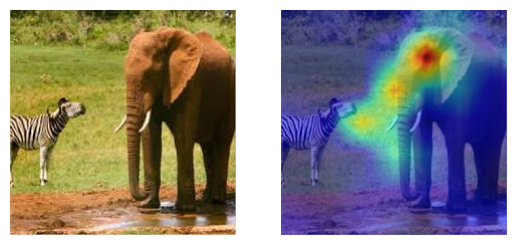

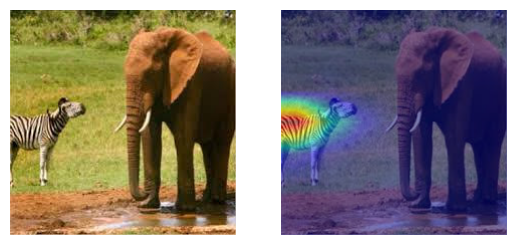

In [13]:
img_path = "images/el1.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ['an elephant', 'a zebra']
text = clip.tokenize(texts).to(device)

R_text, R_image, logits_per_text, logits_per_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

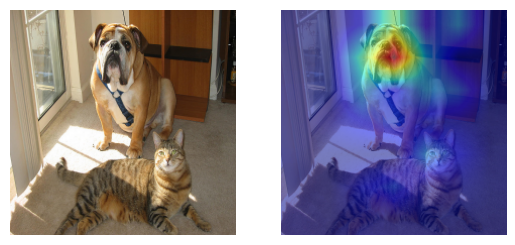

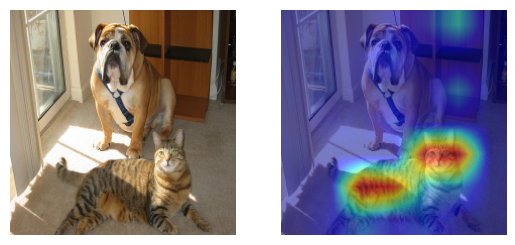

In [14]:
img_path = "images/catdog.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["a dog", "a cat"]
text = clip.tokenize(texts).to(device)

R_text, R_image, logits_per_text, logits_per_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

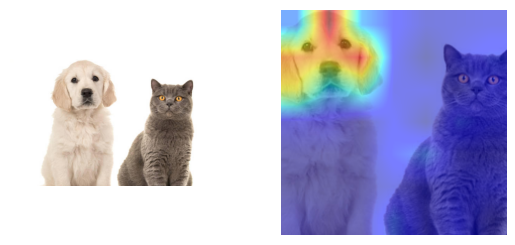

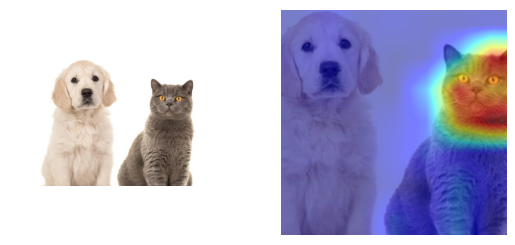

In [15]:
img_path = "images/dogcat2.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["a labrador", "a tabby cat"]
text = clip.tokenize(texts).to(device)

R_text, R_image, logits_per_text, logits_per_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

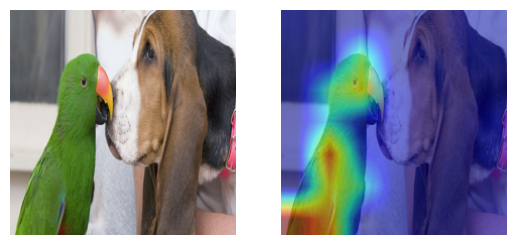

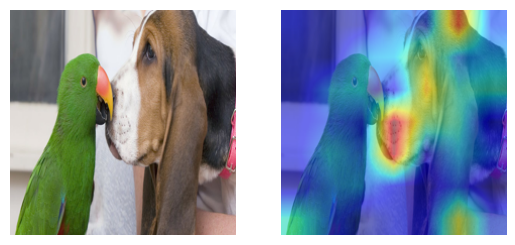

In [16]:
img_path = "images/dogbird.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["a parrot", "a dog"]
text = clip.tokenize(texts).to(device)

R_text, R_image, logits_per_text, logits_per_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

# Examples of biased similarity scores (noise scores higher than dog)

CLIP similarity score: 28.40625


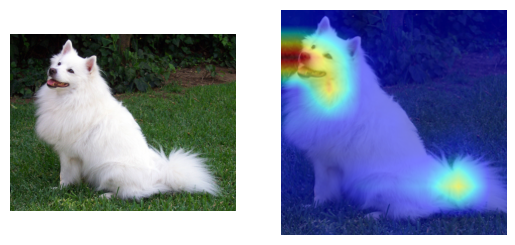

In [17]:
img_path = "images/dog.jpg"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["an image of a dog"]
text = clip.tokenize(texts).to(device)
R_text, R_image, logits_per_text, logits_per_image = interpret(model=model, image=img, texts=text, device=device)
print(color.BOLD + color.PURPLE + color.UNDERLINE + f'CLIP similarity score: {logits_per_image.item()}' + color.END)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

CLIP similarity score: 28.71875


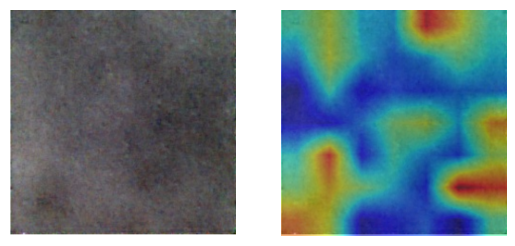

In [18]:
img_path = "images/noise.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["an image of a dog"]
text = clip.tokenize(texts).to(device)
R_text, R_image, logits_per_text, logits_per_image = interpret(model=model, image=img, texts=text, device=device)
print(color.BOLD + color.PURPLE + color.UNDERLINE + f'CLIP similarity score: {logits_per_image.item()}' + color.END)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()